



 # 一个简单的扩散-平流方程有限差分求解器

 本示例介绍了`neuralop`库损失模块中的有限差分工具，

 演示了如何使用该工具构建一个简单的数值求解器，用于求解二维扩散-平流方程。





 ## 导入所需库

 首先导入核心库`neuralop`以及其他辅助依赖库。





In [5]:
# 导入PyTorch：用于张量计算和设备管理（CPU/GPU）
import torch
# 导入NumPy：用于数值计算和数组操作
import numpy as np
# 导入matplotlib核心模块：用于绘制静态图形
import matplotlib.pyplot as plt
# 导入matplotlib动画模块：用于生成动态演化动画
import matplotlib.animation as animation

# 从neuralop的损失模块中导入有限差分工具类FiniteDiff
from neuralop.losses.differentiation import FiniteDiff

# 配置计算设备：优先使用CUDA（GPU）加速，若无GPU则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




 ## 定义求解问题

 本示例旨在求解二维扩散-平流方程，其数学表达式如下：



 \begin{align}\frac{\partial u}{\partial t} + c_x \frac{\partial u}{\partial x} + c_y \frac{\partial u}{\partial y} = \nu \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) + f(x,y,t)\end{align}



 其中：

 - $f(x,y,t)$：方程的源项（随空间和时间变化的激励项）

 - $c_x$、$c_y$：分别为x方向和y方向的平流速度（物质输运的宏观速度）

 - $\nu$：扩散系数（描述物质分子扩散强度的参数）

 - $u(x,y,t)$：待求解的未知量（如浓度、温度等物理量）



 下面设置仿真所需的各项参数：





In [6]:
## 仿真核心参数配置
Lx, Ly = 2.0, 2.0  # 计算域的x方向、y方向总长度（模拟的空间范围）
nx, ny = 64, 64    # x方向、y方向的网格点数（网格分辨率，点数越多精度越高，计算量越大）
T = 1.6            # 总仿真时间（模拟的时间跨度）
dt = 0.001         # 时间步长（每次时间迭代的步长，步长越小数值稳定性越好）
nu = 0.02          # 扩散系数（控制扩散效应的强弱，值越大扩散越明显）
cx, cy = 1.0, 0.6  # x方向、y方向的平流速度（控制物质沿空间方向输运的快慢和方向）

## 构建二维空间网格
# 生成x方向均匀网格点，并通过转置和重复扩展为二维网格（形状：[nx, ny]）
X = torch.linspace(0, Lx, nx, device=device).repeat(ny, 1).T
# 生成y方向均匀网格点，并直接重复扩展为二维网格（形状：[nx, ny]）
Y = torch.linspace(0, Ly, ny, device=device).repeat(nx, 1)
# 计算x方向网格步长（相邻网格点的空间距离）
dx = Lx / (nx - 1)
# 计算y方向网格步长
dy = Ly / (ny - 1)
# 计算总时间步数（总仿真时间 / 时间步长，取整）
nt = int(T / dt)

## 初始化有限差分算子
# dim=2：指定求解二维问题
# h=(dx, dy)：传入x、y方向的网格步长，用于有限差分计算
fd = FiniteDiff(dim=2, h=(dx, dy))

## 定义初始条件（t=0时刻，未知量u在空间上的分布）
u = (
    # 第一项：正弦余弦组合的周期性分布
    -torch.sin(2 * np.pi * Y) * torch.cos(2 * np.pi * X)
    # 第二项：正的高斯分布（局部高值区域）
    + 0.3 * torch.exp(-((X - 0.75) ** 2 + (Y - 0.5) ** 2) / 0.02)
    # 第三项：负的高斯分布（局部低值区域）
    - 0.3 * torch.exp(-((X - 1.25) ** 2 + (Y - 1.5) ** 2) / 0.02)
).to(device)  # 将初始条件张量移至指定计算设备（CPU/GPU）

## 定义方程的源项函数（随空间(X,Y)和时间(t)变化）
def source_term(X, Y, t):
    """
    扩散-平流方程的源项f(x,y,t)
    参数：
        X: 二维网格的x坐标张量
        Y: 二维网格的y坐标张量
        t: 当前时刻的时间值
    返回：
        对应空间和时间下的源项值张量
    """
    return 0.2 * torch.sin(3 * np.pi * X) * torch.cos(3 * np.pi * Y) * torch.cos(4 * np.pi * t)




 ## 使用数值求解器模拟未知量u的时间演化

 采用**欧拉方法**（显式时间步进方法）对扩散-平流方程进行数值求解，

 逐步计算每个时间步长后未知量u的空间分布。



In [7]:
# 初始化列表，用于保存u在所有时间步的分布结果（保存克隆值，避免后续修改覆盖历史数据）
u_evolution = [u.clone()]

# 初始化当前时刻为0.0
t = torch.tensor(0.0)
# 遍历所有时间步，进行数值迭代求解
for _ in range(nt):
    # 利用有限差分算子计算u的各阶空间偏导数
    u_x = fd.dx(u)   # 一阶偏导数∂u/∂x（x方向）
    u_y = fd.dy(u)   # 一阶偏导数∂u/∂y（y方向）
    u_xx = fd.dx(u_x)# 二阶偏导数∂²u/∂x²（x方向二阶导数，通过对一阶导数再求导得到）
    u_yy = fd.dy(u_y)# 二阶偏导数∂²u/∂y²（y方向二阶导数）

    # 采用欧拉方法进行单步时间演化更新
    # 核心公式：u(t+dt) = u(t) + dt * [方程右侧的时间变化率]
    # 方程右侧：-c_x∂u/∂x -c_y∂u/∂y（平流项） + ν(∂²u/∂x²+∂²u/∂y²)（扩散项） + f(x,y,t)（源项）
    u = u + dt * (-cx * u_x - cy * u_y + nu * (u_xx + u_yy) + source_term(X, Y, t))
    
    # 更新当前时刻（进入下一个时间步）
    t += dt
    
    # 保存当前时间步的u分布（克隆避免后续迭代修改历史数据）
    u_evolution.append(u.clone())

# 将保存的所有时间步u数据堆叠为张量，并移至CPU转换为NumPy数组（方便后续绘图和动画生成）
u_evolution = torch.stack(u_evolution).cpu().numpy()




 ## 生成仿真结果动画

 将所有时间步的u分布转换为动态动画，直观展示其时间演化过程。



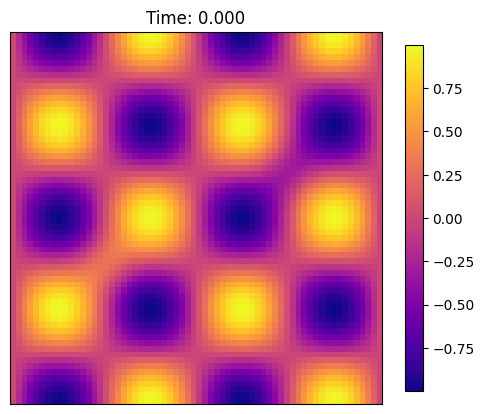

In [8]:
# 定义动画的总帧数（从所有时间步中采样，避免帧数过多导致动画过大）
num_frames = 100
# 从所有演化结果的索引中，均匀采样指定帧数的索引（保证动画节奏均匀）
frame_indices = (
    torch.linspace(0, len(u_evolution) - 1, num_frames, dtype=torch.int).cpu().numpy()
)
# 根据采样索引提取对应的u分布数据（动画帧数据）
u_frames = u_evolution[frame_indices]

# 创建绘图窗口和坐标轴，设置窗口大小为6x6
fig, ax = plt.subplots(figsize=(6, 6))
# 初始化热力图：展示第一帧的u分布，设置坐标范围、原点位置和颜色映射
cmap_u = ax.imshow(u_frames[0], extent=[0, Lx, 0, Ly], origin="lower", cmap="plasma")
# 设置坐标轴标题（描述当前展示的物理量）
ax.set_title("Advection-Diffusion: u")
# 添加颜色条，用于对应热力图的颜色和数值大小，缩小75%避免遮挡
plt.colorbar(cmap_u, ax=ax, shrink=0.75)

## 定义动画更新函数（每帧动画的更新逻辑）
def update(frame):
    """
    动画帧更新函数
    参数：
        frame: 当前动画帧的索引
    返回：
        更新后的热力图对象（用于matplotlib动画渲染）
    """
    # 更新热力图的数据为当前帧的u分布
    cmap_u.set_data(u_frames[frame])
    # 更新坐标轴标题，显示当前帧对应的仿真时间（保留3位小数）
    ax.set_title(f"Time: {frame_indices[frame] * dt:.3f}")
    # 隐藏x轴刻度（简化图形展示）
    ax.set_xticks([])
    # 隐藏y轴刻度（简化图形展示）
    ax.set_yticks([])
    # 返回更新后的热力图对象（保持动画接口一致性）
    return (cmap_u,)

# 创建FuncAnimation动画对象，生成动态演示
# fig: 绘图窗口对象
# update: 帧更新函数
# frames: 动画总帧数
# interval: 每帧之间的时间间隔（单位：毫秒）
# blit: 是否开启局部更新优化（False表示全图更新，兼容性更好）
ani = animation.FuncAnimation(fig, update, frames=len(u_frames), interval=50, blit=False)
ani.save("advection_diffusion_evolution.gif",writer='pillow', fps=20)  # 将动画保存为GIF文件，设置每秒帧数为20


 ## 生成三维空间中的解的动态变化动画

 利用3D曲面图展示u(x,y,t)在三维空间（x, y, u）中的时间演化过程，更直观地观察其空间分布的高低起伏变化。

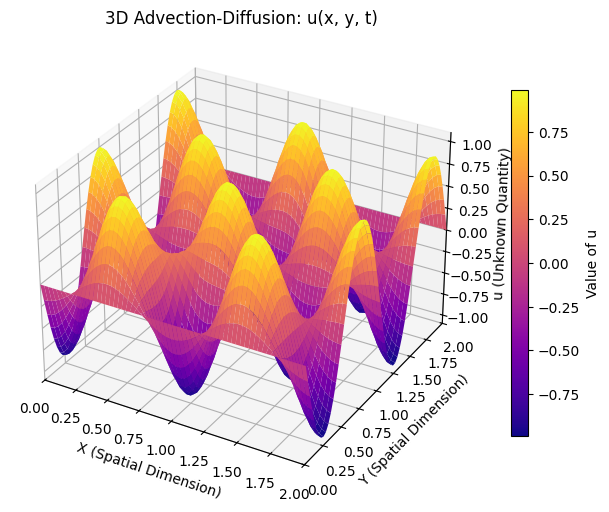

In [10]:
from mpl_toolkits.mplot3d import Axes3D  # 导入3D绘图所需工具包

# 1. 准备3D绘图的空间网格数据（转换为numpy数组，匹配u_frames的数据格式）
X_np = X.cpu().numpy()  # 原有x方向二维网格转numpy数组
Y_np = Y.cpu().numpy()  # 原有y方向二维网格转numpy数组

# 2. 创建3D绘图窗口
fig_3d = plt.figure(figsize=(10, 6))
ax_3d = fig_3d.add_subplot(111, projection='3d')  # 指定3D投影模式

# 3. 初始化3D曲面（绘制第一帧数据，作为动画的初始状态）
# rstride/cstride：曲面网格的行/列步长（值越大，网格线越少，渲染越快）
# cmap：颜色映射，与2D动画保持一致（plasma），保证视觉统一性
# linewidth：曲面网格线宽度，0表示隐藏网格线
# antialiased：是否开启抗锯齿，让曲面更平滑
surf = ax_3d.plot_surface(
    X_np, Y_np, u_frames[0],
    rstride=1, cstride=1,
    cmap="plasma",
    linewidth=0,
    antialiased=True
)

# 4. 设置3D坐标轴的标签、标题和范围（固定坐标轴范围，避免动画过程中坐标轴抖动）
ax_3d.set_xlabel('X (Spatial Dimension)', fontsize=10)
ax_3d.set_ylabel('Y (Spatial Dimension)', fontsize=10)
ax_3d.set_zlabel('u (Unknown Quantity)', fontsize=10)
ax_3d.set_title('3D Advection-Diffusion: u(x, y, t)', fontsize=12)
# 固定x、y轴范围（与计算域一致），z轴范围根据所有帧的极值自动适配，避免超出视野
z_min = np.min(u_frames)
z_max = np.max(u_frames)
ax_3d.set_zlim(z_min - 0.1, z_max + 0.1)
ax_3d.set_xlim(0, Lx)
ax_3d.set_ylim(0, Ly)

# 5. 添加颜色条（对应3D曲面的颜色与数值映射关系）
fig_3d.colorbar(surf, ax=ax_3d, shrink=0.75, label='Value of u')

# 6. 定义3D动画的更新函数（每帧动画的刷新逻辑）
def update_3d(frame):
    """
    3D动画帧更新函数
    参数：
        frame: 当前动画帧的索引
    返回：
        更新后的3D曲面对象（用于matplotlib动画渲染）
    """
    # 清除当前坐标轴的原有曲面（避免多曲面叠加导致渲染混乱和性能下降）
    ax_3d.clear()
    
    # 重新绘制当前帧的3D曲面（保持与初始曲面相同的样式参数）
    surf = ax_3d.plot_surface(
        X_np, Y_np, u_frames[frame],
        rstride=1, cstride=1,
        cmap="plasma",
        linewidth=0,
        antialiased=True
    )
    
    # 重新设置坐标轴标签、标题和范围（清除后需要重新配置，避免坐标轴丢失）
    ax_3d.set_xlabel('X (Spatial Dimension)', fontsize=10)
    ax_3d.set_ylabel('Y (Spatial Dimension)', fontsize=10)
    ax_3d.set_zlabel('u (Unknown Quantity)', fontsize=10)
    ax_3d.set_title(f'3D Advection-Diffusion: Time = {frame_indices[frame] * dt:.3f}', fontsize=12)
    ax_3d.set_zlim(z_min - 0.1, z_max + 0.1)
    ax_3d.set_xlim(0, Lx)
    ax_3d.set_ylim(0, Ly)
    
    return (surf,)

# 7. 创建3D动画对象
ani_3d = animation.FuncAnimation(
    fig_3d,                # 3D绘图窗口对象
    update_3d,             # 3D帧更新函数
    frames=len(u_frames),  # 动画总帧数（与2D动画保持一致）
    interval=50,           # 每帧间隔时间（毫秒，与2D动画保持一致）
    blit=False             # 3D曲面更新不支持局部优化，需设置为False
)

# 可选：显示绘图窗口（在Jupyter Notebook中可能自动显示，本地运行需手动调用）
plt.show()
ani_3d.save("3d_advection_diffusion_evolution.gif", writer='pillow', fps=20)  # 将3D动画保存为GIF文件，设置每秒帧数为20